# Crop HRDPS Continental GRIB2 File with `xarray` and `cfgrib`

Exploration of loading a ECCC MSC 2.5 km rotated lat-lon continental grid HRDPS GRIB2 file,
cropping it to the sub-domain needed for SalishSeaCast NEMO forcing,
and writing it to a new GRIB2 file.

`cfgrib`:
* code: https://github.com/ecmwf/cfgrib
* docs in README: https://github.com/ecmwf/cfgrib/blob/master/README.rst
* example in xarray docs: https://docs.xarray.dev/en/stable/examples/ERA5-GRIB-example.html

`conda` environment description for this notebook: `analysis-doug/notebooks/continental-HRDPS/environment-cfgrib.yaml`

This notebook assumes that the MOAD `/results/` file system is mounted.

In [2]:
from pathlib import Path
import textwrap

import arrow
from cfgrib import xarray_to_grib
import matplotlib.pyplot as plt
import xarray
import yaml

In [2]:
grib_dir = Path("/results/forcing/atmospheric/continental2.5/GRIB/20230215/00/")
u_grib = Path("001", "20230215T00Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H.grib2")

In [3]:
! ls -lh /results/forcing/atmospheric/continental2.5/GRIB/20230215/00/001/20230215T00Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H.grib2

-rw-rw-r-- 1 1557 210 1.8M Feb 26 00:44 /results/forcing/atmospheric/continental2.5/GRIB/20230215/00/001/20230215T00Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H.grib2


In [4]:
ds = xarray.open_dataset(grib_dir/u_grib, engine="cfgrib")

ds

<xarray.Dataset>
Dimensions:            (y: 1290, x: 2540)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-30T10:33 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
crop_ds = ds.sel(y=slice(230, 461), x=slice(300, 491))

crop_ds

<xarray.Dataset>
Dimensions:            (y: 231, x: 191)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-29T11:03 GRIB to CDM+CF via cfgrib-0.9.1...

Discovered that `xarray.open_dataset(..., engine="cfgrib")` relies on
`GRIB_Nx` and `GRIB_Ny` variable attribute values,
but those don't get adjusted by ``ds.sel(y=slice(230, 461), x=slice(300, 491))``.
So, adjust those attr values, and the value of `GRIB_numberOfPoints` for consistency.

In [5]:
crop_ds.u10.attrs.update(
    {
        "GRIB_numberOfPoints": 44121,
        "GRIB_Nx": 191,
        "GRIB_Ny": 231,
    }
)

In [6]:
xarray_to_grib.to_grib(crop_ds, "/tmp/test.grib2")

/home/doug/conda_envs/cfgrib-grib_to_netcdf/lib/python3.10/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
unknown 'typeOfLevel': 'heightAboveGround'. Using GRIB2 template


In [7]:
test_ds = xarray.open_dataset("/tmp/test.grib2", engine="cfgrib")

test_ds

Ignoring index file '/tmp/test.grib2.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:            (y: 231, x: 191)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-29T11:03 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
!ls -lh /tmp/test.grib2

-rw-rw-r-- 1 doug doug 130K Mar 29 11:03 /tmp/test.grib2


In [16]:
(130*1024) / (1.8*1024**2)

0.07052951388888888

A ~93% size reduction!!!

## Dev Sketching for `crop_gribs` worker

In [21]:
config = yaml.safe_load(
    textwrap.dedent(
        """\
        weather:
            download:
                2.5 km:
                    GRIB dir: /results/forcing/atmospheric/continental2.5/GRIB/
                    MSC file template: "{date}T{forecast}Z_MSC_HRDPS_{variable}_RLatLon0.0225_PT{hour}H.grib2"
                    SSC cropped file template: "{date}T{forecast}Z_MSC_HRDPS_{variable}_RLatLon0.0225_PT{hour}H_SSC.grib2"
                    variables:
                        # [MSC name, GRIB std name, NEMO name]
                        - [UGRD_AGL-10m, u10, u_wind]           # u component of wind velocity at 10m elevation
                        - [VGRD_AGL-10m, v10, v_wind]           # v component of wind velocity at 10m elevation
                        - [DSWRF_Sfc, ssrd, solar]              # accumulated downward shortwave (solar) radiation at ground level
                        - [DLWRF_Sfc, strd, therm_rad]          # accumulated downward longwave (thermal) radiation at ground level
                        - [LHTFL_Sfc, lhtfl, LHTFL_surface]     # upward surface latent heat flux (for VHFR FVCOM)
                        - [TMP_AGL-2m, t2m, tair]               # air temperature at 2m elevation
                        - [SPFH_AGL-2m, sh2, qair]              # specific humidity at 2m elevation
                        - [RH_AGL-2m, r2, RH_2maboveground]     # relative humidity at 2m elevation (for VHFR FVCOM)
                        - [APCP_Sfc, unknown, precip]           # accumulated precipitation at ground level
                        - [PRATE_Sfc, prate, PRATE_surface]     # precipitation rate at ground level (for VHFR FVCOM)
                        - [PRMSL_MSL, prmsl, atmpres]           # atmospheric pressure at mean sea level
                    lon indices: [300, 490]
                    lat indices: [230, 460]
                    forecast duration: 48  # hours
        """
    )
)

In [22]:
grib_dir = Path(config["weather"]["download"]["2.5 km"]["GRIB dir"])
msc_file_tmpl = config["weather"]["download"]["2.5 km"]["MSC file template"]
ssc_file_tmpl = config["weather"]["download"]["2.5 km"]["SSC cropped file template"]
var_names = config["weather"]["download"]["2.5 km"]["variables"]
y_min, y_max = config["weather"]["download"]["2.5 km"]["lat indices"]
x_min, x_max = config["weather"]["download"]["2.5 km"]["lon indices"]
# We need 1 point more than the final domain size to facilitate calculation of the
# grid rotation angle for the wind components
y_slice = slice(y_min, y_max + 1)
x_slice = slice(x_min, x_max + 1)
fcst_dur = config["weather"]["download"]["2.5 km"]["forecast duration"]

In [31]:
fcst_date = arrow.get("2023-03-29")
fcst_yyyymmdd = fcst_date.format("YYYYMMDD")
forecast = "06"

In [47]:
ny, nx = y_max - y_min + 1, x_max - x_min + 1
for fcst_step in range(1, 2):
    grib_hr_dir = grib_dir / Path(fcst_yyyymmdd, forecast, f"{fcst_step:03d}")
    for msc_var, grib_var, _ in var_names:
        msc_grib_file = msc_file_tmpl.format(
            date=fcst_yyyymmdd,
            forecast=forecast,
            variable=msc_var,
            hour=f"{fcst_step:03d}",
        )
        ssc_grib_file = ssc_file_tmpl.format(
            date=fcst_yyyymmdd,
            forecast=forecast,
            variable=msc_var,
            hour=f"{fcst_step:03d}",
        )
        with xarray.open_dataset(
            grib_hr_dir/msc_grib_file, engine="cfgrib", backend_kwargs={"indexpath": ""}
        ) as msc_ds:
            ssc_ds = msc_ds.sel(y=y_slice, x=x_slice)
        ssc_ds[grib_var].attrs.update(
            {
                "GRIB_numberOfPoints": nx*ny,
                "GRIB_Nx": nx,
                "GRIB_Ny": ny,
            }
        )
        xarray_to_grib.to_grib(ssc_ds, grib_hr_dir/ssc_grib_file)


/home/doug/conda_envs/cfgrib-grib_to_netcdf/lib/python3.10/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
unknown 'typeOfLevel': 'heightAboveGround'. Using GRIB2 template
/home/doug/conda_envs/cfgrib-grib_to_netcdf/lib/python3.10/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
unknown 'typeOfLevel': 'heightAboveGround'. Using GRIB2 template
/home/doug/conda_envs/cfgrib-grib_to_netcdf/lib/python3.10/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
failed to set key 'paramId' to 169
ECCODES ERROR   :  grib_set_values[4] typeOfStati

In [48]:
!ls -lh /results/forcing/atmospheric/continental2.5/GRIB/20230329/06/001

25315.60s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


total 20M
-rw-r--r-- 1 1557 210 1.7M Mar 29 01:59 20230329T06Z_MSC_HRDPS_APCP_Sfc_RLatLon0.0225_PT001H.grib2
-rwxr-xr-x 1 1557 210 1.2K Mar 29 17:58 20230329T06Z_MSC_HRDPS_APCP_Sfc_RLatLon0.0225_PT001H.grib2.923a8.idx
-rw-r--r-- 1 1557 210 130K Mar 29 18:05 20230329T06Z_MSC_HRDPS_APCP_Sfc_RLatLon0.0225_PT001H_SSC.grib2
-rw-r--r-- 1 1557 210 2.2M Mar 29 01:59 20230329T06Z_MSC_HRDPS_DLWRF_Sfc_RLatLon0.0225_PT001H.grib2
-rwxr-xr-x 1 1557 210 1.2K Mar 29 17:58 20230329T06Z_MSC_HRDPS_DLWRF_Sfc_RLatLon0.0225_PT001H.grib2.923a8.idx
-rw-r--r-- 1 1557 210 130K Mar 29 18:04 20230329T06Z_MSC_HRDPS_DLWRF_Sfc_RLatLon0.0225_PT001H_SSC.grib2
-rw-r--r-- 1 1557 210  217 Mar 29 01:59 20230329T06Z_MSC_HRDPS_DSWRF_Sfc_RLatLon0.0225_PT001H.grib2
-rwxr-xr-x 1 1557 210 1.2K Mar 29 17:58 20230329T06Z_MSC_HRDPS_DSWRF_Sfc_RLatLon0.0225_PT001H.grib2.923a8.idx
-rw-r--r-- 1 1557 210  215 Mar 29 18:04 20230329T06Z_MSC_HRDPS_DSWRF_Sfc_RLatLon0.0225_PT001H_SSC.grib2
-rw-r--r-- 1 1557 210 1.3M Mar 29 01:59 20230329T06

In [52]:
ssc_ds = xarray.open_dataset(
    grib_hr_dir/"20230329T06Z_MSC_HRDPS_APCP_Sfc_RLatLon0.0225_PT001H_SSC.grib2",
    engine="cfgrib",
    backend_kwargs={"indexpath": ""},
)

ssc_ds

<xarray.Dataset>
Dimensions:     (y: 231, x: 191)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    t           (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-29T18:20 GRIB to CDM+CF via cfgrib-0.9.1...

`to_grib()` didn't like GRIB var name `unknown` in ACPC file and stored the variable as
`t` aka `air_temperature` :-(

So, I need to compare the data structures and metadata of the original MSC files and the cropped
SSC files carefully.

In [64]:
fcst_step = 1
grib_hr_dir = grib_dir / Path(fcst_yyyymmdd, forecast, f"{fcst_step:03d}")
msc_vars = [var[0] for var in var_names]

msc_var = msc_vars[0]
print(msc_var)
msc_grib_file = msc_file_tmpl.format(
    date=fcst_yyyymmdd,
    forecast=forecast,
    variable=msc_var,
    hour=f"{fcst_step:03d}",
)
ssc_grib_file = ssc_file_tmpl.format(
    date=fcst_yyyymmdd,
    forecast=forecast,
    variable=msc_var,
    hour=f"{fcst_step:03d}",
)


UGRD_AGL-10m


In [9]:
msc_ds = xarray.open_dataset(
    grib_hr_dir/msc_grib_file, engine="cfgrib", backend_kwargs={"indexpath": ""}
)

msc_ds

<xarray.Dataset>
Dimensions:            (y: 1290, x: 2540)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-30T10:35 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
ssc_ds = xarray.open_dataset(
    grib_hr_dir/ssc_grib_file, engine="cfgrib", backend_kwargs={"indexpath": ""}
)

ssc_ds

<xarray.Dataset>
Dimensions:            (y: 231, x: 191)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-30T10:35 GRIB to CDM+CF via cfgrib-0.9.1...

In [74]:
def check_attrs(msc_var, show_details=False):
    print(msc_var)
    fcst_step = 1
    grib_hr_dir = grib_dir / Path(fcst_yyyymmdd, forecast, f"{fcst_step:03d}")

    msc_grib_file = msc_file_tmpl.format(
        date=fcst_yyyymmdd,
        forecast=forecast,
        variable=msc_var,
        hour=f"{fcst_step:03d}",
    )
    msc_ds = xarray.open_dataset(
        grib_hr_dir/msc_grib_file, engine="cfgrib", backend_kwargs={"indexpath": ""}
    )
    ssc_grib_file = ssc_file_tmpl.format(
        date=fcst_yyyymmdd,
        forecast=forecast,
        variable=msc_var,
        hour=f"{fcst_step:03d}",
    )
    ssc_ds = xarray.open_dataset(
        grib_hr_dir/ssc_grib_file, engine="cfgrib", backend_kwargs={"indexpath": ""}
    )
    
    checks = [
        msc_ds.coords[coord].attrs == ssc_ds.coords[coord].attrs 
        for coord in msc_ds.coords.keys()
    ]
    print(f"Coordinate attributes: {all(checks)}")
    if show_details:
        for coord, check in zip(msc_ds.coords.keys(), checks):
            print(f"  {coord}: {check}")
        print()

    msc_var_name = [var for var in msc_ds.data_vars][0]
    excl_attrs = {"GRIB_Nx", "GRIB_Ny", "GRIB_numberOfPoints"}
    var_attrs = (
        {attr for attr in msc_ds[msc_var_name].attrs if attr not in excl_attrs}.union(
            {attr for attr in ssc_ds[msc_var_name].attrs if attr not in excl_attrs}
        )
    )
    checks = [
        msc_ds[msc_var_name].attrs[attr] == ssc_ds[msc_var_name].attrs[attr]
        for attr in var_attrs
    ]
    print(f"Variable attributes: {all(checks)}")
    if show_details:
        for attr, check in zip(var_attrs, checks):
            print(f"  {attr}: {check}")
        print()

    ds_attrs = (
        {attr for attr in msc_ds.attrs if attr != "history"}.union(
            {attr for attr in ssc_ds.attrs if attr != "history"}
        )
    )
    checks = [
        msc_ds.attrs[attr] == ssc_ds.attrs[attr]
        for attr in ds_attrs
    ]
    print(f"Dataset attributes: {all(checks)}")
    if show_details:
        for attr, check in zip(ds_attrs, checks):
            print(f"  {attr}: {check}")
        print()

    return msc_ds, ssc_ds


In [88]:
msc_vars = [var[0] for var in var_names]

for msc_var in msc_vars[:8]:
    msc_ds, ssc_ds = check_attrs(msc_var, show_details=False)
    print()

for msc_var in msc_vars[9:]:
    msc_ds, ssc_ds = check_attrs(msc_var, show_details=False)
    print()

UGRD_AGL-10m
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True

VGRD_AGL-10m
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True

DSWRF_Sfc
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True

DLWRF_Sfc
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True

LHTFL_Sfc
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True

TMP_AGL-2m
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True

SPFH_AGL-2m
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True

RH_AGL-2m
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True

PRATE_Sfc
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True

PRMSL_MSL
Coordinate attributes: True
Variable attributes: True
Dataset attributes: True



In [90]:
msc_var = msc_vars[8]
msc_ds, ssc_ds = check_attrs(msc_var, show_details=True)

APCP_Sfc
Coordinate attributes: True
  time: True
  step: True
  surface: True
  latitude: True
  longitude: True
  valid_time: True



KeyError: 'unknown'

So, ACPC is the only variable that needs remedial work.

In [111]:
ny, nx = y_max - y_min + 1, x_max - x_min + 1
for fcst_step in range(1, 2):
    grib_hr_dir = grib_dir / Path(fcst_yyyymmdd, forecast, f"{fcst_step:03d}")
    msc_var, grib_var, _ = var_names[8]
    msc_grib_file = msc_file_tmpl.format(
        date=fcst_yyyymmdd,
        forecast=forecast,
        variable=msc_var,
        hour=f"{fcst_step:03d}",
    )
    ssc_grib_file = ssc_file_tmpl.format(
        date=fcst_yyyymmdd,
        forecast=forecast,
        variable=msc_var,
        hour=f"{fcst_step:03d}",
    )
    with xarray.open_dataset(
        grib_hr_dir/msc_grib_file, engine="cfgrib", backend_kwargs={"indexpath": ""}
    ) as msc_ds:
        ssc_ds = msc_ds.sel(y=y_slice, x=x_slice)
    ssc_ds[grib_var].attrs.update(
        {
            "GRIB_numberOfPoints": nx*ny,
            "GRIB_Nx": nx,
            "GRIB_Ny": ny,
            "GRIB_paramId": 162108,
            "GRIB_cfName": "precipitation_amount",
            "GRIB_cfVarName": "precipitation_amount",
            "GRIB_name": "Total Precipitation flux",
            "GRIB_shortName": "tpfa",
            "GRIB_units": "kg m-2",
            "long_name": "Total Precipitation flux",
            "standard_name": "precipitation_amount",
            "units": "kg m-2",
        }
    )
    ssc_ds = ssc_ds.rename_vars(unknown="tot_prec")
    xarray_to_grib.to_grib(ssc_ds, grib_hr_dir/ssc_grib_file)

ssc_ds


/home/doug/conda_envs/cfgrib-grib_to_netcdf/lib/python3.10/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
failed to set key 'paramId' to 162108
ECCODES ERROR   :  concept: no match for paramId=162108
ECCODES ERROR   :  concept: input handle edition=2, centre=cwao
ECCODES ERROR   :  Please check the Parameter Database 'https://apps.ecmwf.int/codes/grib/param-db/?id=162108'
failed to set key 'cfName' to 'precipitation_amount'
ECCODES ERROR   :  concept: no match for cfName=precipitation_amount
ECCODES ERROR   :  concept: input handle edition=2, centre=cwao
failed to set key 'cfVarName' to 'precipitation_amount'
ECCODES ERROR   :  concept: no match for cfVarName=precipitation_amount
ECCODES ERROR   :  concept: input handle edition=2, centre=cwao
failed to set key 'name' to 'Total Precipitation flux'
ECCODES ERROR   :  concept: no match

<xarray.Dataset>
Dimensions:     (y: 231, x: 191)
Coordinates:
    time        datetime64[ns] 2023-03-29T06:00:00
    step        timedelta64[ns] 01:00:00
    surface     float64 0.0
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] 2023-03-29T07:00:00
Dimensions without coordinates: y, x
Data variables:
    tot_prec    (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-30T16:09 GRIB to CDM+CF via cfgrib-0.9.1...

In [113]:
ssc_ds = xarray.open_dataset(
    grib_hr_dir/"20230329T06Z_MSC_HRDPS_APCP_Sfc_RLatLon0.0225_PT001H_SSC.grib2",
    engine="cfgrib",
    backend_kwargs={"indexpath": ""},
)

ssc_ds

<xarray.Dataset>
Dimensions:     (y: 231, x: 191)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    t           (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-30T16:10 GRIB to CDM+CF via cfgrib-0.9.1...

Hrmph! In spite of all the metadata work and renaming the variable, `to_grib()`
still changed the variable and its metadata to `air_temperature` :-(

Revised GRIB2 writer:

In [36]:
ny, nx = y_max - y_min + 1, x_max - x_min + 1
for fcst_step in range(17, 17 + 1):
    grib_hr_dir = grib_dir / Path(fcst_yyyymmdd, forecast, f"{fcst_step:03d}")
    for msc_var, grib_var, _ in var_names:
        msc_grib_file = msc_file_tmpl.format(
            date=fcst_yyyymmdd,
            forecast=forecast,
            variable=msc_var,
            hour=f"{fcst_step:03d}",
        )
        ssc_grib_file = ssc_file_tmpl.format(
            date=fcst_yyyymmdd,
            forecast=forecast,
            variable=msc_var,
            hour=f"{fcst_step:03d}",
        )
        with xarray.open_dataset(
            grib_hr_dir/msc_grib_file, engine="cfgrib", backend_kwargs={"indexpath": ""}
        ) as msc_ds:
            ssc_ds = msc_ds.sel(y=y_slice, x=x_slice)
        ssc_ds[grib_var].attrs.update(
            {
                "GRIB_numberOfPoints": nx*ny,
                "GRIB_Nx": nx,
                "GRIB_Ny": ny,
            }
        )
        if msc_var == "APCP_Sfc":
            ssc_ds[grib_var].attrs.update(
                {
                "GRIB_paramId": 500041,
                "GRIB_cfName": "precipitation_flux",
                "GRIB_cfVarName": "tot_prec",
                "GRIB_name": "Total Precipitation rate (S)",
                "GRIB_shortName": "tot_prec",
                "GRIB_units": "kg m-2 s-1",
                }
            )
            ssc_ds = ssc_ds.rename_vars(unknown="tot_prec")

        xarray_to_grib.to_grib(ssc_ds, grib_hr_dir/ssc_grib_file)


NameError: name 'ssc' is not defined

Processed the files generated by the above cell with hacked version of
`grib_to_netcdf forecast2 --run-date 2023-0329` and successfully produced
`/results/forcing/atmospheric/continental2.5/fcst/hrdps_y2023m03d30.nc`.
It's fields compare well with 
`/results/forcing/atmospheric/continental2.5/nemo_forcing/hrdps_y2023m03d30.nc`
when Susan plotted them on xy grid index axes, 
but there is something very wrong with the lon/lat values.

/tmp/ipykernel_32669/1382643742.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax2.pcolormesh(ds.nav_lon, ds.nav_lat, ds.u_wind[0])


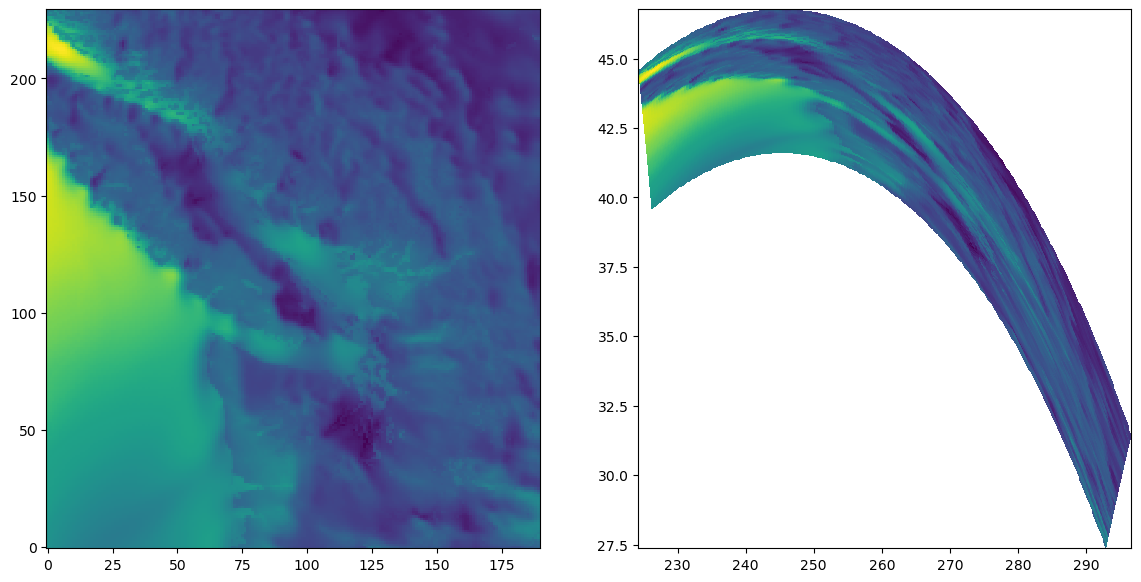

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
with xarray.open_dataset("/results/forcing/atmospheric/continental2.5/fcst/hrdps_y2023m03d30.nc") as ds:
    ax1.pcolormesh(ds.x, ds.y, ds.u_wind[0])
    ax2.pcolormesh(ds.nav_lon, ds.nav_lat, ds.u_wind[0])

Not good!
Let's look at the cropped GRIB file:

/tmp/ipykernel_32669/600031339.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax2.pcolormesh(ds.longitude, ds.latitude, ds.u10)


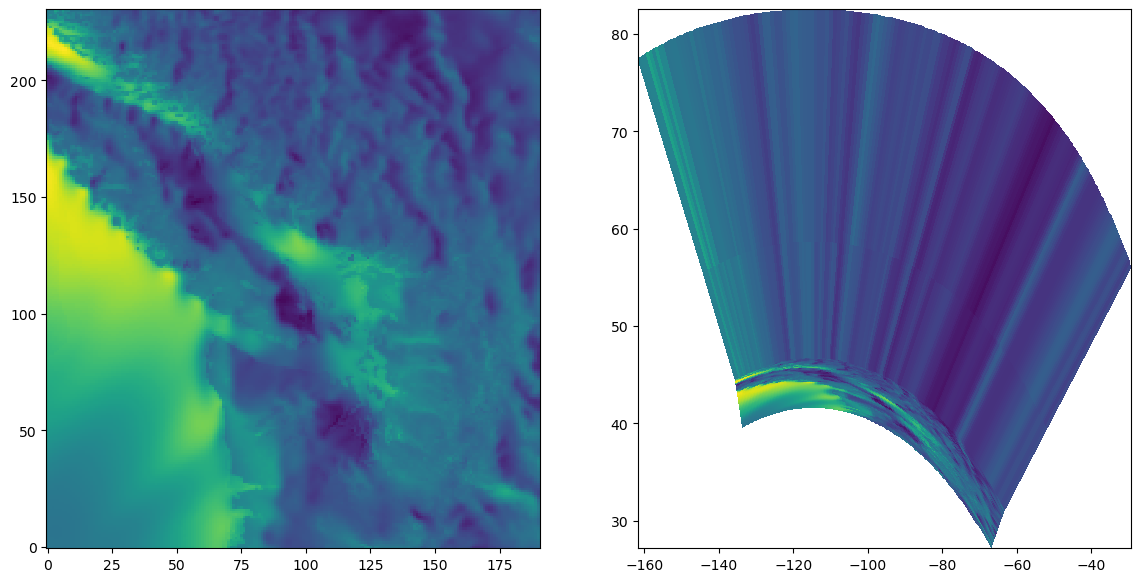

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
with xarray.open_dataset(
    "/results/forcing/atmospheric/continental2.5/GRIB/20230329/06/017/20230329T06Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT017H_SSC.grib2",
    engine="cfgrib",
    backend_kwargs={"indexpath": ""},
) as ds:
    ax1.pcolormesh(ds.x, ds.y, ds.u10)
    ax2.pcolormesh(ds.longitude, ds.latitude, ds.u10)


Also not good!
What about the original, full continental domain GRIB file?

46.123396 51.794516
-126.290664 -120.836512


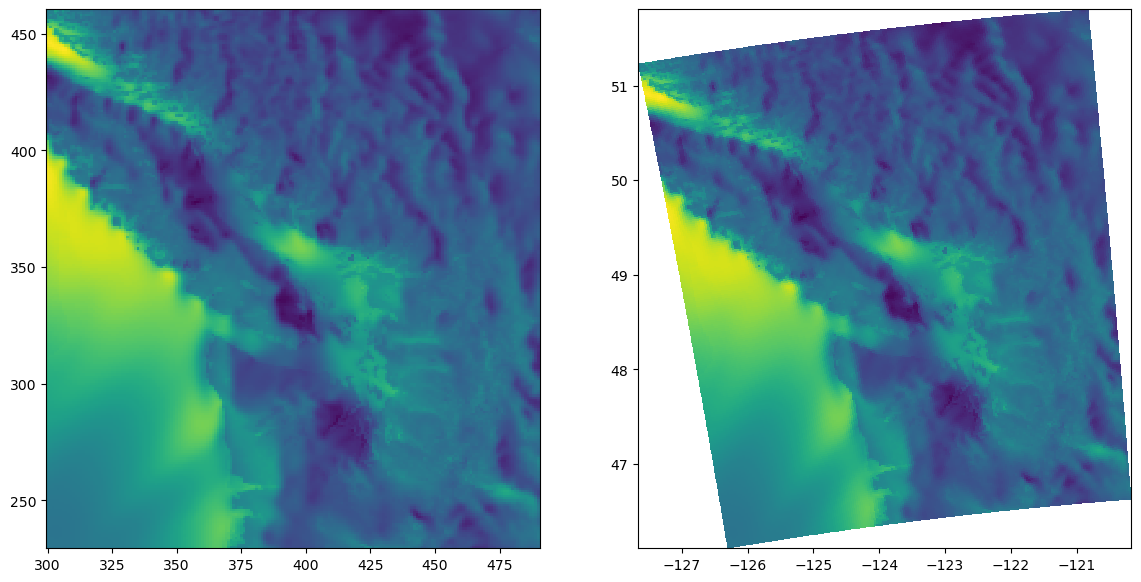

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
with xarray.open_dataset(
    "/results/forcing/atmospheric/continental2.5/GRIB/20230329/06/017/20230329T06Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT017H.grib2",
    engine="cfgrib",
    backend_kwargs={"indexpath": ""},
) as ds:
    ax1.pcolormesh(ds.x.isel(x=x_slice), ds.y.isel(y=y_slice), ds.u10.sel(y=y_slice, x=x_slice))
    ax2.pcolormesh(ds.longitude.sel(y=y_slice, x=x_slice), ds.latitude.sel(y=y_slice, x=x_slice), ds.u10.sel(y=y_slice, x=x_slice))

print(ssc_ds.latitude[0, 0].data, ssc_ds.latitude[-1, -1].data)
print(ssc_ds.longitude[0, 0].data, ssc_ds.longitude[-1, -1].data)

Good!
What about the netCDF file that `grib_to_netcdf` calculated from files like
the above?

232.364968 239.7822
46.123396 51.770148


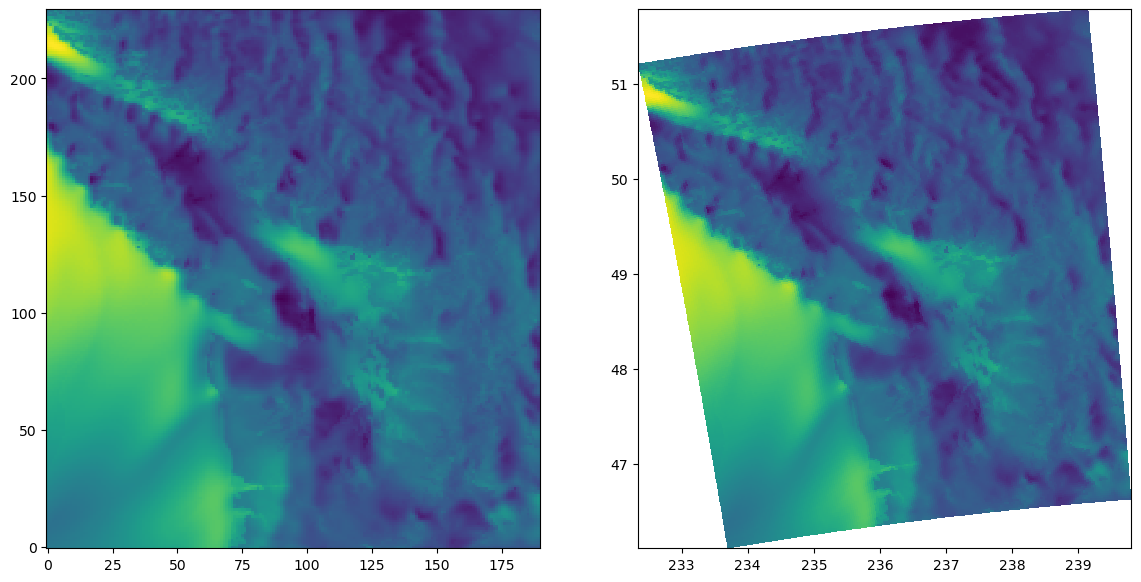

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
with xarray.open_dataset("/results/forcing/atmospheric/continental2.5/nemo_forcing/hrdps_y2023m03d30.nc") as ds:
    ax1.pcolormesh(ds.x, ds.y, ds.u_wind[0])
    ax2.pcolormesh(ds.nav_lon, ds.nav_lat, ds.u_wind[0])
    print(ds.nav_lon.data.min(), ds.nav_lon.data.max())
    print(ds.nav_lat.data.min(), ds.nav_lat.data.max())

Good! Check the cropped dataset before it is written to a GRIB file:

In [38]:
ny, nx = y_max - y_min + 1, x_max - x_min + 1
for fcst_step in range(1, 2):
    grib_hr_dir = grib_dir / Path(fcst_yyyymmdd, forecast, f"{fcst_step:03d}")
    msc_var, grib_var, _ = var_names[0]
    msc_grib_file = msc_file_tmpl.format(
        date=fcst_yyyymmdd,
        forecast=forecast,
        variable=msc_var,
        hour=f"{fcst_step:03d}",
    )
    ssc_grib_file = ssc_file_tmpl.format(
        date=fcst_yyyymmdd,
        forecast=forecast,
        variable=msc_var,
        hour=f"{fcst_step:03d}",
    )
    with xarray.open_dataset(
        grib_hr_dir/msc_grib_file, engine="cfgrib", backend_kwargs={"indexpath": ""}
    ) as msc_ds:
        ssc_ds = msc_ds.sel(y=y_slice, x=x_slice)
    ssc_ds[grib_var].attrs.update(
        {
            "GRIB_numberOfPoints": nx*ny,
            "GRIB_Nx": nx,
            "GRIB_Ny": ny,
        }
    )

ssc_ds


<xarray.Dataset>
Dimensions:            (y: 231, x: 191)
Coordinates:
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  float64 ...
    latitude           (y, x) float64 ...
    longitude          (y, x) float64 ...
    valid_time         datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    u10                (y, x) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             cwao
    GRIB_centreDescription:  Canadian Meteorological Service - Montreal
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Canadian Meteorological Service - Montreal
    history:                 2023-03-31T14:34 GRIB to CDM+CF via cfgrib-0.9.1...

In [46]:
ssc_ds.longitude.min().data+360, ssc_ds.longitude.max().data+360

(232.358464, 239.814616)

In [48]:
ssc_ds.latitude.min().data, ssc_ds.latitude.max().data

(array(46.123396), array(51.794516))

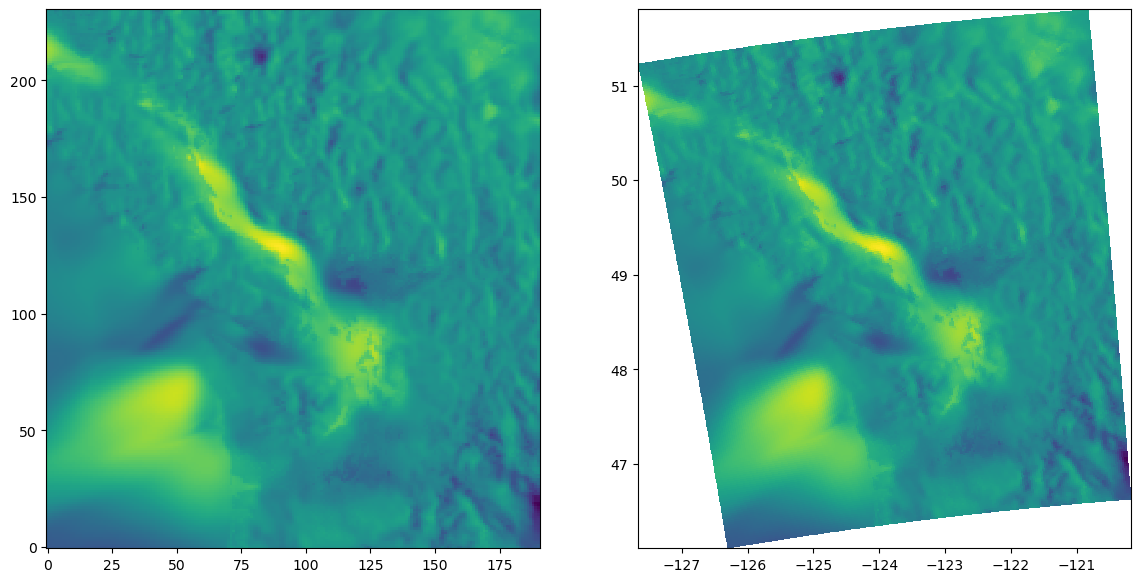

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.pcolormesh(ssc_ds.x, ssc_ds.y, ssc_ds.u10)
ax2.pcolormesh(ssc_ds.longitude, ssc_ds.latitude, ssc_ds.u10)


Good! Can we manipulate the GRIB grid corners metadata to get the correct
lon/lats in the GRIB file?

In [52]:
ssc_ds.u10.attrs

{'GRIB_paramId': 165,
 'GRIB_dataType': 'af',
 'GRIB_numberOfPoints': 44121,
 'GRIB_typeOfLevel': 'heightAboveGround',
 'GRIB_stepUnits': 1,
 'GRIB_stepType': 'instant',
 'GRIB_gridType': 'rotated_ll',
 'GRIB_NV': 0,
 'GRIB_Nx': 191,
 'GRIB_Ny': 231,
 'GRIB_angleOfRotationInDegrees': 0.0,
 'GRIB_cfName': 'eastward_wind',
 'GRIB_cfVarName': 'u10',
 'GRIB_gridDefinitionDescription': 'Rotated latitude/longitude',
 'GRIB_iDirectionIncrementInDegrees': 0.0225,
 'GRIB_iScansNegatively': 0,
 'GRIB_jDirectionIncrementInDegrees': 0.0225,
 'GRIB_jPointsAreConsecutive': 0,
 'GRIB_jScansPositively': 1,
 'GRIB_latitudeOfFirstGridPointInDegrees': -12.302501,
 'GRIB_latitudeOfLastGridPointInDegrees': 16.700001,
 'GRIB_latitudeOfSouthernPoleInDegrees': -36.08852,
 'GRIB_longitudeOfFirstGridPointInDegrees': 345.17878,
 'GRIB_longitudeOfLastGridPointInDegrees': 42.306283,
 'GRIB_longitudeOfSouthernPoleInDegrees': 245.305142,
 'GRIB_missingValue': 3.4028234663852886e+38,
 'GRIB_name': '10 metre U wind co

In [61]:
ssc_ds.latitude[0, 0].data, ssc_ds.latitude[-1, -1].data

(array(46.123396), array(51.794516))

In [56]:
ssc_ds.longitude[0, 0].data, ssc_ds.longitude[-1, -1].data

(array(-126.290664), array(-120.836512))

In [62]:
ssc_ds.u10.attrs.update(
    {
        'GRIB_latitudeOfFirstGridPointInDegrees': ssc_ds.latitude[0, 0].data.item(),
        'GRIB_latitudeOfLastGridPointInDegrees': ssc_ds.latitude[-1, -1].data.item(),
        'GRIB_longitudeOfFirstGridPointInDegrees': ssc_ds.longitude[0, 0].data.item(),
        'GRIB_longitudeOfLastGridPointInDegrees': ssc_ds.longitude[-1, -1].data.item(),
    }
)

ssc_ds.u10.attrs

{'GRIB_paramId': 165,
 'GRIB_dataType': 'af',
 'GRIB_numberOfPoints': 44121,
 'GRIB_typeOfLevel': 'heightAboveGround',
 'GRIB_stepUnits': 1,
 'GRIB_stepType': 'instant',
 'GRIB_gridType': 'rotated_ll',
 'GRIB_NV': 0,
 'GRIB_Nx': 191,
 'GRIB_Ny': 231,
 'GRIB_angleOfRotationInDegrees': 0.0,
 'GRIB_cfName': 'eastward_wind',
 'GRIB_cfVarName': 'u10',
 'GRIB_gridDefinitionDescription': 'Rotated latitude/longitude',
 'GRIB_iDirectionIncrementInDegrees': 0.0225,
 'GRIB_iScansNegatively': 0,
 'GRIB_jDirectionIncrementInDegrees': 0.0225,
 'GRIB_jPointsAreConsecutive': 0,
 'GRIB_jScansPositively': 1,
 'GRIB_latitudeOfFirstGridPointInDegrees': 46.123396,
 'GRIB_latitudeOfLastGridPointInDegrees': 51.794516,
 'GRIB_latitudeOfSouthernPoleInDegrees': -36.08852,
 'GRIB_longitudeOfFirstGridPointInDegrees': -126.290664,
 'GRIB_longitudeOfLastGridPointInDegrees': -120.836512,
 'GRIB_longitudeOfSouthernPoleInDegrees': 245.305142,
 'GRIB_missingValue': 3.4028234663852886e+38,
 'GRIB_name': '10 metre U wind

In [63]:
xarray_to_grib.to_grib(ssc_ds, grib_hr_dir/ssc_grib_filea)

/home/doug/conda_envs/cfgrib-grib_to_netcdf/lib/python3.10/site-packages/cfgrib/xarray_to_grib.py:261: FutureWarning: GRIB write support is experimental, DO NOT RELY ON IT!
  warnings.warn("GRIB write support is experimental, DO NOT RELY ON IT!", FutureWarning)
unknown 'typeOfLevel': 'heightAboveGround'. Using GRIB2 template


In [66]:
grib_hr_dir/ssc_grib_file

PosixPath('/results/forcing/atmospheric/continental2.5/GRIB/20230329/06/001/20230329T06Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H_SSC.grib2')

In [67]:
ll -h "/results/forcing/atmospheric/continental2.5/GRIB/20230329/06/001/20230329T06Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H_SSC.grib2"

9151.38s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


-rw-r--r-- 1 1557 130K Mar 31 15:10 /results/forcing/atmospheric/continental2.5/GRIB/20230329/06/001/20230329T06Z_MSC_HRDPS_UGRD_AGL-10m_RLatLon0.0225_PT001H_SSC.grib2


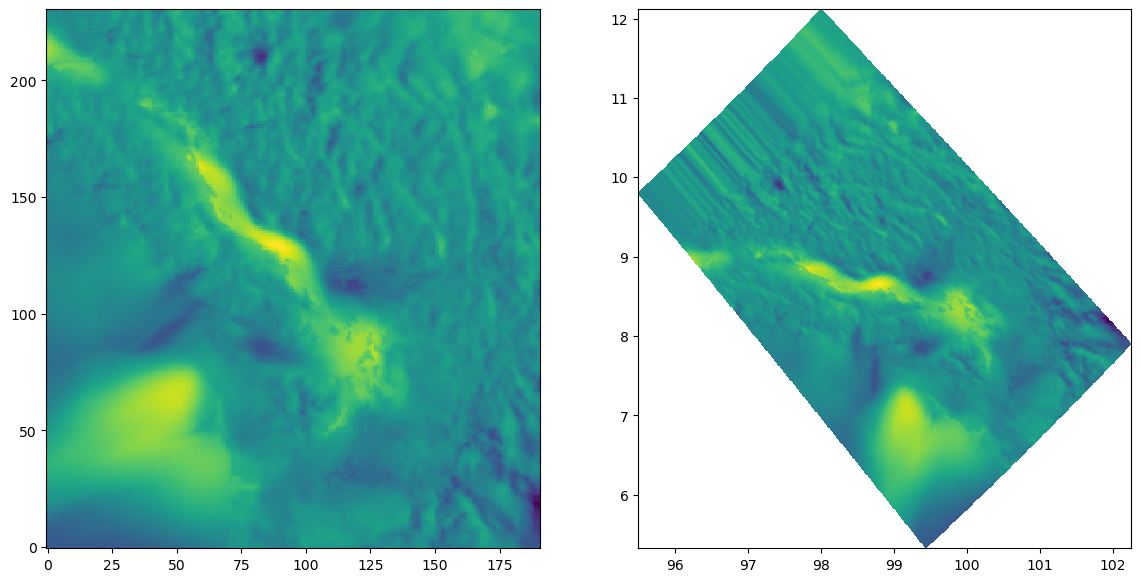

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
with xarray.open_dataset(
    grib_hr_dir/ssc_grib_file,
    engine="cfgrib",
    backend_kwargs={"indexpath": ""},
) as ds:
    ax1.pcolormesh(ds.x, ds.y, ds.u10)
    ax2.pcolormesh(ds.longitude, ds.latitude, ds.u10)


In [69]:
ds.u10.attrs

{'GRIB_paramId': 165,
 'GRIB_dataType': 'af',
 'GRIB_numberOfPoints': 44121,
 'GRIB_typeOfLevel': 'heightAboveGround',
 'GRIB_stepUnits': 1,
 'GRIB_stepType': 'instant',
 'GRIB_gridType': 'rotated_ll',
 'GRIB_NV': 0,
 'GRIB_Nx': 191,
 'GRIB_Ny': 231,
 'GRIB_angleOfRotationInDegrees': 0.0,
 'GRIB_cfName': 'eastward_wind',
 'GRIB_cfVarName': 'u10',
 'GRIB_gridDefinitionDescription': 'Rotated latitude/longitude',
 'GRIB_iDirectionIncrementInDegrees': 0.0225,
 'GRIB_iScansNegatively': 0,
 'GRIB_jDirectionIncrementInDegrees': 0.0225,
 'GRIB_jPointsAreConsecutive': 0,
 'GRIB_jScansPositively': 1,
 'GRIB_latitudeOfFirstGridPointInDegrees': 46.123396,
 'GRIB_latitudeOfLastGridPointInDegrees': 51.794516,
 'GRIB_latitudeOfSouthernPoleInDegrees': -36.08852,
 'GRIB_longitudeOfFirstGridPointInDegrees': 233.709336,
 'GRIB_longitudeOfLastGridPointInDegrees': 239.163488,
 'GRIB_longitudeOfSouthernPoleInDegrees': 245.305142,
 'GRIB_missingValue': 3.4028234663852886e+38,
 'GRIB_name': '10 metre U wind c

Nope! Something about the lons/lats changed, but they're still not correct.

Giving up on this!
It's either poorly/undocumented behaviour of GRIB,
or a bug in the (admittedly alpha/experimental) `cfgrib.xarray_to_grib.to_grib()`.

Strategy to move forward:
* cropping the continental domain GRIBs to a sub-grid that encloses the SalishSeCast NEMO
  domain is a win in terms of storage footprint,
  and probably in terms of processing time:
  cropping adds time, but `grib_to_netcdf` on cropped GRIBs seems to be way faster
  than on full domain GRIBs

* add a `--full-continental-grid` option with a default value of `False` to 
  `grib_to_netcdf`

* store a 191x231 geo-reference dataset for the in-process cropped dataset at
  `/results/forcing/atmospheric/continental2.5/GRIB/SSC_grid_georef.nc` and use it
  to set the `nav_lon` and `nav_lat` coordinate arrays in 
  `SalishSeaNowcast.nowcast.workers.grib_to_netcdf._calc_nemo_var_ds()`

Test the result of that strategy:

In [4]:
!ls -lh /results/forcing/atmospheric/continental2.5/fcst/hrdps_y2023m03d30.nc

-rw-r--r-- 1 1557 210 30M Apr  1 12:43 /results/forcing/atmospheric/continental2.5/fcst/hrdps_y2023m03d30.nc


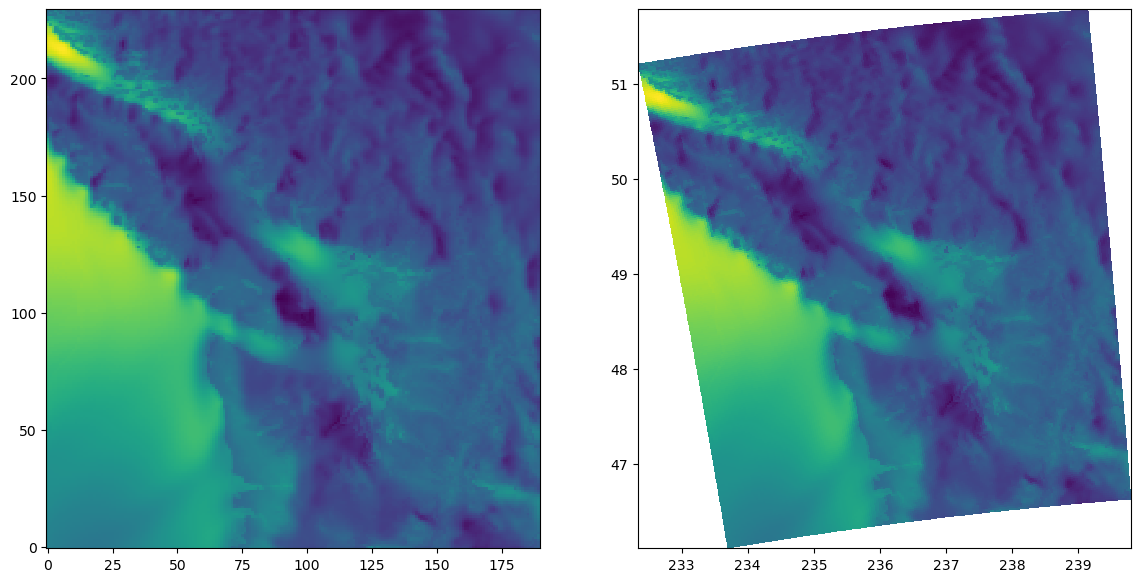

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
with xarray.open_dataset("/results/forcing/atmospheric/continental2.5/fcst/hrdps_y2023m03d30.nc") as ds:
    ax1.pcolormesh(ds.x, ds.y, ds.u_wind[0])
    ax2.pcolormesh(ds.nav_lon, ds.nav_lat, ds.u_wind[0])